In [1]:
from bs4 import BeautifulSoup 
from selenium import webdriver
# The following packages will also be used in this tutorial
import pandas as pd # All database operations
import numpy as np  # Numerical operations
import time         # Tracking time
import requests     # HTTP requests
import re           # String manipulation
from sklearn.feature_extraction.text import CountVectorizer # BagOfWords (cleaning)
from joblib import Parallel, delayed # Parallellization of tasks

In [2]:
import itertools

In [4]:
def getPage(url):
	''' returns a soup object that contains all the information 
	of a certain webpage'''
	result = requests.get(url)
	content = result.content
	return BeautifulSoup(content, features = "lxml")

url_page ="https://www.airbnb.fr/s/Paris--France/homes?adults=1&place_id=ChIJD7fiBh9u5kcRYJSMaMOCCwQ&refinement_paths%5B%5D=%2Fhomes&checkin=2020-12-30&checkout=2020-12-31"
page=getPage(url_page)

In [5]:
def getRoomClasses(soupPage):
	''' This function returns all the listings that can 
	be found on the page in a list.'''
	rooms = soupPage.findAll("div", {"class": "_8ssblpx"})
	result = []
	for room in rooms:
		result.append(room)
	return result
listing=getRoomClasses(page)

In [6]:
##commentaires
def getNbCommentaire(listing):
	''' Returns the guest information'''
	try:
		return listing.find("span", {"class":"_a7a5sx"}).text 
	except:
		return "pas de commentaire"

##evaluation
def getEvaluation(listing):
	''' Returns the guest information'''
	try:
		return listing.find("span", {"class":"_10fy1f8"}).text 
	except:
		return "pas d'évaluation"

## lien du logement
def getListingLink(listing):
	''' Returns the guest information'''
	try:
		return "http://airbnb.com" + listing.find("a")["href"]
	except:
		return "pas de lien"

## titre du logement
def getListingTitle(listing):
	''' Returns the guest information'''
	try:
		return listing.find("meta")["content"]
	except:
		return "pas de titre du logement"

##description du logement
def getTopRow(listing):
	''' Returns the guest information'''
	try:
		return listing.find("div", {"class": "_167qordg"}).text
	except:
		return "pas de description du logement"   
    
##information sur le nombre de chambre/douche
def getRoomInfo(listing):
	''' Returns the guest information'''
	try:
		return listing.find("div", {"class":"_kqh46o"}).text
	except:
		return "pas d'infos sur chambre/douche"
    
##prix
def getPrix(listing):
	''' Returns the guest information'''
	try:
		return listing.find("div", {"class":"_1fwiw8gv"}).text
	except:
		return "pas d'infos sur le prix"

In [7]:
## extraction des infos de tous les logements d'une page

def extractinfo(page):
    df = pd.DataFrame(columns = ['title', 'link',"nbComments","prix","topRow","evaluation","roomInfo"]) ##,"evaluation", ,'nbComments'
    new=[]
    listing=getRoomClasses(page)
    for i in range(1, len(listing)):
        new.append(getListingTitle(listing[i]))
        new.append(getListingLink(listing[i]))
        new.append(getNbCommentaire(listing[i]))
        new.append(getPrix(listing[i]))
        new.append(getTopRow(listing[i]))
        new.append(getEvaluation(listing[i]))
        new.append(getRoomInfo(listing[i]))
        df.loc[i]=new
        new=[]
    return df

In [8]:
## il faut ajouter des dates aux liens pour voir les prix
def findNextPage(soupPage):
	''' Finds the next page with listings if it exists '''
	try:
		nextpage = "https://airbnb.com" + soupPage.find("a", {"class": "_za9j7e"})["href"]
	except: # When he can't find the button, I assume he reached the end
		nextpage = "no next page"
	return nextpage
url=findNextPage(page)
url

'https://airbnb.com/s/Paris--France/homes?checkin=2020-12-30&refinement_paths%5B%5D=%2Fhomes&adults=1&checkout=2020-12-31&tab_id=home_tab&place_id=ChIJD7fiBh9u5kcRYJSMaMOCCwQ&federated_search_session_id=0ff673ed-1cc7-4019-8c1a-c4e3467747a3&search_type=pagination&items_offset=20&section_offset=3'

In [9]:
## nombre de page du site web
def getPages(url):
	''' This function returns all the links to the pages containing 
	listings for one particular city '''
	result = []
	while url != "no next page": 
		page = getPage(url)
		result = result + [page]
		url = findNextPage(page)
	return result
URL=getPages(url_page)
len(URL)

15

In [10]:
## Scrapper toutes les infos sur les logements
def extractPages(url):
	''' This function outputs a dataframe that contains all information of a particular
	city. It thus contains information of multiple listings coming from multiple pages.'''
	pages = getPages(url)
	# Do for the first element to initialize the dataframe
	df =extractinfo(pages[0])
	# Loop over all other elements of the dataframe
	for pagenumber in range(1, len(pages)):
		df = df.append(extractinfo(pages[pagenumber]))
	return df

In [11]:
##base de tous les logements avec les évaluations
data=pd.DataFrame.from_dict(extractPages(url_page))
data.head(5)

,title,link,nbComments,prix,topRow,evaluation,roomInfo
1,Logement Privé Relaxant avec grand Jaccusi &Ja...,http://airbnb.com/rooms/15443356?adults=1&chec...,(292),Prix :129€ / nuit,Chambre privée à Rosny-sous-Bois,4.68,"2 voyageurs · 1 chambre · 1 lit · 1,5 salle de..."
2,The Place To Be // Trendy Eiffel Tower Apartme...,http://airbnb.com/rooms/46465358?adults=1&chec...,(3),Prix :190€ / nuit,Logement entier à Tour Eiffel - Champ de Mars,5.0,2 voyageurs · Studio · 1 lit · 1 salle de bain
3,"Espace partagé, Shared space - null - Saint-Denis",http://airbnb.com/rooms/9975524?adults=1&check...,(443),Prix :20€ / nuit,Chambre partagée à La Chapelle,4.58,2 voyageurs · 1 chambre · 1 lit · 1 salle de b...
4,""" Parisien Male Dorm Shared Room ”- Metro 5 - ...",http://airbnb.com/rooms/46833581?adults=1&chec...,pas de commentaire,Prix :8€ / nuit,Chambre partagée à Bobigny,pas d'évaluation,"1 voyageur · 1 chambre · 0 lit · 1,5 salle de ..."
5,"Nordic Design Suite, w/ private terrace - null...",http://airbnb.com/rooms/23575562?adults=1&chec...,(5),Prix :271€ / nuit,Chambre d'hôtel à 18e arrondissement,4.60,2 voyageurs · 1 chambre · 1 lit · 1 salle de bain


In [86]:
## exportation de la base des listingd
len(data.index)
import csv
data.to_csv('D:\Python\dataListing.csv', index = True)

In [ ]:
## scrapper les commentaires de chaque logement

In [12]:
from selenium import webdriver
import time
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
from selenium.webdriver.common.action_chains import ActionChains 




In [88]:
help(webdriver.Chrome().get)

Help on method get in module selenium.webdriver.remote.webdriver:

get(url) method of selenium.webdriver.chrome.webdriver.WebDriver instance
    Loads a web page in the current browser session.



In [13]:
## installer chrome driver
#driver = webdriver.Chrome()
driver_path = 'D:/chromedriver.exe'
opt = webdriver.ChromeOptions()
opt.add_experimental_option('w3c', False)
driver = webdriver.Chrome(executable_path=driver_path,options=opt)

##Initialiser le driver de Selenium
def setupDriver(url, waiting_time = 5):
	driver = webdriver.Chrome(options=opt)
	driver.get(url)
	time.sleep(waiting_time) 
	return driver


In [14]:

## charger chaque listing
def getJSpage(url):
	driver = setupDriver(url)
	html = driver.page_source
	driver.close()
	return BeautifulSoup(html, features="lxml")

# lien de la page des commentaires de chaque listing
def getCommentLink(soupPage):
	try:
		return "https://www.airbnb.fr" + soupPage.find("div", {"class": "_19qg1ru"}).find("a")["href"]
	except:
		return "pas de lien"

##Recuperer l'ensemble des commentaires
def getRoomComments(soupage):
    #try
    crooms=soupage.findAll('div', {'class': '_1gjypya'})
    result=[]
    for room in crooms:
        result.append(room)
    return result

def getcomments(result):
    comments=[]
    for i in result:
        try:
            comments.append(i.find('div', {'class': '_1y6fhhr'}).text)
        except: 
            pass
    return comments



In [15]:
##Scrolling
def ScrollPagecomments(url):
    driver=setupDriver(url)
    num_current_comment_found = 0
    pre_scroll_num_of_comment=-1
    comment_class_when_scrolling  = '_1gjypya'
    time.sleep(5)
    while (num_current_comment_found != pre_scroll_num_of_comment) :           
                visible_comments = driver.find_elements_by_class_name(comment_class_when_scrolling)
                pre_scroll_num_of_comment= len(visible_comments)
                try:
                    last_visible_comment = visible_comments[-1]
                    actions = ActionChains(driver)
                    actions.move_to_element(last_visible_comment)
                    actions.perform()
                    time.sleep(2)
                    last_visible_comment.location_once_scrolled_into_view
                    visible_comments = driver.find_elements_by_class_name(comment_class_when_scrolling)
                    num_current_comment_found = len(visible_comments)
                except:
                    pass
    html=driver.page_source
    driver.close()
    return BeautifulSoup(html,features="lxml")

In [16]:
##EXTRACTION DES COMMENTAIRES
def ExtractionCommentaire(data):
    ind=[]
    com=[]
    DataComments=[]
    i=0
    for link in data['link']:
        soupPage=getJSpage(link)
        url_comment=getCommentLink(soupPage)
        if (url_comment!="pas de lien"):
            js=ScrollPagecomments(url_comment)
            DataComments=getcomments(getRoomComments(js))
            #a=getcomments(getRoomComments(js))
        else :
            DataComments=["pas de commentaire"]
        i=i+1
        ind=ind+list(itertools.repeat(i, len(DataComments)))
        com=com + DataComments
        database=pd.DataFrame.from_dict({'index':ind, 'commentaires':com})
        database.to_csv('D:\Python\database.csv', index = False, encoding = 'utf-8')
    return database

In [17]:
df=pd.read_csv('C:/Users/GIL TIOGUIM/Desktop/Projet_python/TP_py/Projet/TP2A-master/final_database.csv')

In [18]:
df2=pd.read_csv('C:/Users/GIL TIOGUIM/Desktop/Projet_python/TP_py/Projet/TP2A-master/final_dataListing.csv')

In [19]:
df_test=df2[df2['nbComments']=='pas de commentaire']
df_test.shape

(59, 8)

In [20]:
df2['nbComments'] = df2['nbComments'].str.replace(r'\D','')

In [21]:
df2['nbComments']=np.where(df2['nbComments']=='',0,df2['nbComments'])

In [22]:
df2['evaluation']=np.where(df2['evaluation']=="pas d'évaluation",0,df2['evaluation'])

In [30]:
df2.head(50)

,Unnamed: 0,title,link,nbComments,prix,topRow,evaluation,roomInfo
0,1,The Place To Be // Trendy Eiffel Tower Apartme...,http://airbnb.com/rooms/46465358?adults=1&chec...,0,190,Logement entier à Tour Eiffel - Champ de Mars,0,2 voyageurs · Studio · 1 lit · 1 salle de bain
1,2,La Chambre & Piscine - null - Paris,http://airbnb.com/rooms/31868079?adults=1&chec...,174,120,Chambre d'hôtel à Vaugirard,4.84,2 voyageurs · 1 chambre · 1 lit · 1 salle de bain
2,3,Secret Deluxe Room in the heart of Paris - nul...,http://airbnb.com/rooms/33703579?adults=1&chec...,18,97,Chambre d'hôtel à 9e arrondissement,4.61,2 voyageurs · 1 chambre · 1 lit · 1 salle de bain
3,4,Chaleureux studio pour 4 personnes - null - Bo...,http://airbnb.com/rooms/41310751?adults=1&chec...,0,77,Logement entier à Bobigny,0,3 voyageurs · Studio · 4 lits · 1 salle de bain
4,5,Champs Elysées - Ponthieu 61 : appt. cosy pour...,http://airbnb.com/rooms/46789810?adults=1&chec...,0,94,Logement entier à 8e arrondissement,0,4 voyageurs · 1 chambre · 2 lits · 1 salle de ...
5,6,NO Louvre - Etienne Marcel 301 : appt. cosy po...,http://airbnb.com/rooms/46785554?adults=1&chec...,0,102,Logement entier à 2e arrondissement,0,2 voyageurs · Studio · 1 lit · 1 salle de bain
6,7,Logement Privé Relaxant avec grand Jaccusi &Ja...,http://airbnb.com/rooms/15443356?adults=1&chec...,291,129,Chambre privée à Rosny-sous-Bois,4.68,"2 voyageurs · 1 chambre · 1 lit · 1,5 salle de..."
7,8,"Chambre déco industrielle ""Amsterdam"", accès S...",http://airbnb.com/rooms/18984480?adults=1&chec...,185,86,Chambre dans un boutique-hôtel à 17e arrondiss...,4.58,2 voyageurs · 1 chambre · 1 lit · 1 salle de b...
8,9,Belle chambre au centre de Paris - null - Paris,http://airbnb.com/rooms/1250856?adults=1&check...,453,46,Chambre privée à Quartier Latin,4.69,1 voyageur · 1 chambre · 1 lit · 1 salle de ba...
9,10,"Espace partagé, Shared space - null - Saint-Denis",http://airbnb.com/rooms/9975524?adults=1&check...,441,19,Chambre partagée à La Chapelle,4.58,2 voyageurs · 1 chambre · 1 lit · 1 salle de b...


In [27]:
df2['prix']=df2['prix'].str.replace(":", "/").str.split("/",n = 0, expand = True)[1]
df2['prix']=df2['prix'].str.replace('€','')
df2['prix']=df2['prix'].str.replace('Prix réduit','')
df2['prix']=df2['prix'].str.replace('Discounted price','')



In [29]:
def conversion(df):
    n=len(df)
    for i in range(n):
        try:
            df[i]=float(df[i])
        except:
            df[i]=1.21*float(df[i].strip('$'))
    return df
df2['prix']=conversion(df2['prix'])

<ipython-input-29-753bda059803>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=float(df[i])
<ipython-input-29-753bda059803>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=1.21*float(df[i].strip('$'))


In [32]:
df2.loc[:, "nbComments"] = pd.to_numeric(df2.nbComments)
df2.sort_values(['nbComments'], ascending=False)

,Unnamed: 0,title,link,nbComments,prix,topRow,evaluation,roomInfo
210,2,Sweet Little Room near St Martin Canal - null ...,http://airbnb.com/rooms/32057469?adults=1&chec...,555,198.44,Room in boutique hotel in La Villette,4.41,2 guests · 1 bedroom · 1 bed · 1 private bath
8,9,Belle chambre au centre de Paris - null - Paris,http://airbnb.com/rooms/1250856?adults=1&check...,453,46,Chambre privée à Quartier Latin,4.69,1 voyageur · 1 chambre · 1 lit · 1 salle de ba...
9,10,"Espace partagé, Shared space - null - Saint-Denis",http://airbnb.com/rooms/9975524?adults=1&check...,441,19,Chambre partagée à La Chapelle,4.58,2 voyageurs · 1 chambre · 1 lit · 1 salle de b...
236,9,MARAIS-BEAUBOURG -5 PEOPLE - null - Paris,http://airbnb.com/rooms/4028574?adults=1&check...,381,234.74,Entire apartment in Châtelet - Les Halles - Be...,4.17,5 guests · 2 bedrooms · 3 beds · 1 bath
184,14,Cosy studio aux Portes de Paris - null - Les L...,http://airbnb.com/rooms/20228806?adults=1&chec...,374,102.85,Entire apartment in XX Arrondissement,4.71,2 guests · Studio · 1 bed · 1 bath
...,...,...,...,...,...,...,...,...
234,7,Appartement de charme - null - Paris,http://airbnb.com/rooms/45322772?adults=1&chec...,0,93.17,Entire apartment in XVIII Arrondissement,0,2 guests · 1 bedroom · 1 bed · 1 bath
232,5,Super cosy et lumineux en plein cœur de Paris ...,http://airbnb.com/rooms/46511315?adults=1&chec...,0,119.79,Entire apartment in I Arrondissement,0,2 guests · Studio · 1 bed · 1 bath
121,8,Très bel appartement proche Paris centre - nul...,http://airbnb.com/rooms/44673333?adults=1&chec...,0,71.39,Shared room in XIII Arrondissement,0,1 guest · 1 bedroom · 2 beds · 1 shared bath
126,13,Vue sur Seine - null - Boulogne-Billancourt,http://airbnb.com/rooms/45114375?adults=1&chec...,0,166.98,Private room in Boulogne-Billancourt,0,2 guests · 1 bedroom · 1 bed · 1 shared bath


In [33]:
df2_nocomment=df2[df2['nbComments']==0]

In [34]:
df_wcomment=df2[df2['nbComments']!=0].sort_values(['nbComments'], ascending=False)

In [35]:
df_wcomment['nbComments'].sum()

20735

In [38]:
n=range(1,286)
df2.drop(['Unnamed: 0'], inplace=True, axis=1)

In [39]:
df2['numero_listing']=n

In [201]:
df.shape

(18087, 2)

In [141]:
#df2.loc[:, "prix"] = pd.to_numeric(df2.prix)
df2.loc[:, "nbComments"] = pd.to_numeric(df2.nbComments)
#df2.loc[:,"evaluation"]=pd.to_numeric(df2['evaluation'])

In [40]:
import matplotlib.pyplot as plt


In [41]:
df2.head(10)

,title,link,nbComments,prix,topRow,evaluation,roomInfo,numero_listing
0,The Place To Be // Trendy Eiffel Tower Apartme...,http://airbnb.com/rooms/46465358?adults=1&chec...,0,190,Logement entier à Tour Eiffel - Champ de Mars,0,2 voyageurs · Studio · 1 lit · 1 salle de bain,1
1,La Chambre & Piscine - null - Paris,http://airbnb.com/rooms/31868079?adults=1&chec...,174,120,Chambre d'hôtel à Vaugirard,4.84,2 voyageurs · 1 chambre · 1 lit · 1 salle de bain,2
2,Secret Deluxe Room in the heart of Paris - nul...,http://airbnb.com/rooms/33703579?adults=1&chec...,18,97,Chambre d'hôtel à 9e arrondissement,4.61,2 voyageurs · 1 chambre · 1 lit · 1 salle de bain,3
3,Chaleureux studio pour 4 personnes - null - Bo...,http://airbnb.com/rooms/41310751?adults=1&chec...,0,77,Logement entier à Bobigny,0,3 voyageurs · Studio · 4 lits · 1 salle de bain,4
4,Champs Elysées - Ponthieu 61 : appt. cosy pour...,http://airbnb.com/rooms/46789810?adults=1&chec...,0,94,Logement entier à 8e arrondissement,0,4 voyageurs · 1 chambre · 2 lits · 1 salle de ...,5
5,NO Louvre - Etienne Marcel 301 : appt. cosy po...,http://airbnb.com/rooms/46785554?adults=1&chec...,0,102,Logement entier à 2e arrondissement,0,2 voyageurs · Studio · 1 lit · 1 salle de bain,6
6,Logement Privé Relaxant avec grand Jaccusi &Ja...,http://airbnb.com/rooms/15443356?adults=1&chec...,291,129,Chambre privée à Rosny-sous-Bois,4.68,"2 voyageurs · 1 chambre · 1 lit · 1,5 salle de...",7
7,"Chambre déco industrielle ""Amsterdam"", accès S...",http://airbnb.com/rooms/18984480?adults=1&chec...,185,86,Chambre dans un boutique-hôtel à 17e arrondiss...,4.58,2 voyageurs · 1 chambre · 1 lit · 1 salle de b...,8
8,Belle chambre au centre de Paris - null - Paris,http://airbnb.com/rooms/1250856?adults=1&check...,453,46,Chambre privée à Quartier Latin,4.69,1 voyageur · 1 chambre · 1 lit · 1 salle de ba...,9
9,"Espace partagé, Shared space - null - Saint-Denis",http://airbnb.com/rooms/9975524?adults=1&check...,441,19,Chambre partagée à La Chapelle,4.58,2 voyageurs · 1 chambre · 1 lit · 1 salle de b...,10


In [47]:
# on fait un left join en ajoutant certaines de la base des listings à celle des commentaires
df3 = pd.merge(df2[['title', 'nbComments', 'evaluation',
                          'topRow', 'prix','numero_listing']], df,
                left_on='numero_listing',right_on ='index', how='left')

In [49]:
df3.head(50)

,title,nbComments,evaluation,topRow,prix,numero_listing,index,commentaires
0,The Place To Be // Trendy Eiffel Tower Apartme...,0,0,Logement entier à Tour Eiffel - Champ de Mars,190,1,1.0,Nous avons passé une très bonne semaine. Incro...
1,The Place To Be // Trendy Eiffel Tower Apartme...,0,0,Logement entier à Tour Eiffel - Champ de Mars,190,1,1.0,"Très bien placé , appartement très convenable ..."
2,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,"Super séjour dans un bel endroit, je recommand..."
3,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,Super hôtel! Accueil charmant! Chambre très co...
4,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,Top dans tous les domaines
5,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,Hôtel que je recommande sans aucune hésitation...
6,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,Excellent hôtel rapport qualité/prix sur Paris...
7,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,"Un bel endroit au calme, hyper bien situé (pro..."
8,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,Un seul mot pour résumer notre week-end sur Pa...
9,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,"Super hôtel, chambre très propre. Un personnel..."


In [91]:
help(driver)

Help on WebDriver in module selenium.webdriver.chrome.webdriver object:

class WebDriver(selenium.webdriver.remote.webdriver.WebDriver)
 |  WebDriver(executable_path='chromedriver', port=0, options=None, service_args=None, desired_capabilities=None, service_log_path=None, chrome_options=None, keep_alive=True)
 |  
 |  Controls the ChromeDriver and allows you to drive the browser.
 |  
 |  You will need to download the ChromeDriver executable from
 |  http://chromedriver.storage.googleapis.com/index.html
 |  
 |  Method resolution order:
 |      WebDriver
 |      selenium.webdriver.remote.webdriver.WebDriver
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, executable_path='chromedriver', port=0, options=None, service_args=None, desired_capabilities=None, service_log_path=None, chrome_options=None, keep_alive=True)
 |      Creates a new instance of the chrome driver.
 |      
 |      Starts the service and then creates new instance of chrome driver.
 |      

Debut du NLP

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

In [52]:
from langdetect import detect
# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [208]:
from langdetect import detect
# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [95]:
df.shape

(18087, 2)

In [53]:
df_withcomment=df3[df3['commentaires']!='pas de commentaire']

In [54]:
%%time
df_withcomment['language'] = df_withcomment['commentaires'].apply(language_detection)

Wall time: 5min 25s


In [55]:
df_withcomment.language.value_counts().head(20)

fr       9536
en       6421
es        572
de        253
ko        197
pt        138
it        127
ca        118
nl        104
zh-cn      94
ro         67
cy         58
id         55
ru         49
ja         40
af         21
so         18
da         14
sv         13
cs         12
Name: language, dtype: int64

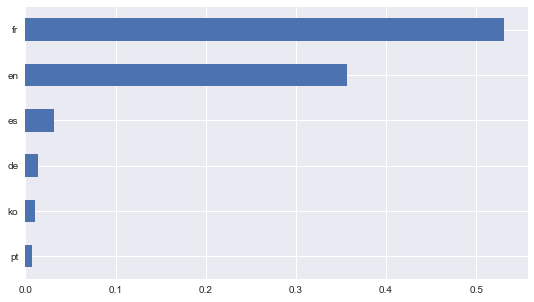

In [56]:
ax = df_withcomment.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

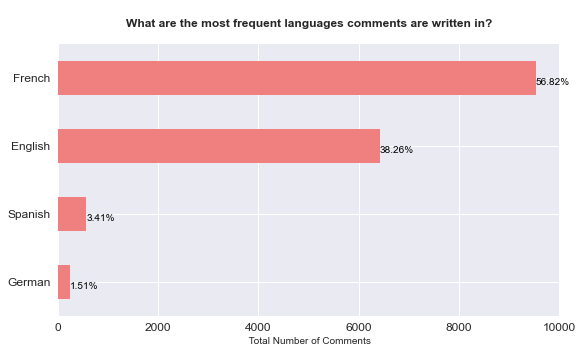

In [57]:
ax = df_withcomment.language.value_counts().head(4).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['French','English','Spanish', 'German'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

In [58]:
df_eng = df_withcomment[(df_withcomment['language']=='en')]
df_es  = df_withcomment[(df_withcomment['language']=='es')]
df_fr  = df_withcomment[(df_withcomment['language']=='fr')]

3. Visualizing the Data with WordClouds

In [61]:
df_es.head(20)

,title,nbComments,evaluation,topRow,prix,numero_listing,index,commentaires,language
106,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,"Un gran alojamiento, habitación impecable y co...",es
113,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,He estado con mi pareja. \nNos ha gustado much...,es
130,La Chambre & Piscine - null - Paris,174,4.84,Chambre d'hôtel à Vaugirard,120,2,2.0,"El hotel súper cómodo, bonito y súper limpio, ...",es
374,Logement Privé Relaxant avec grand Jaccusi &Ja...,291,4.68,Chambre privée à Rosny-sous-Bois,129,7,7.0,Bon accueil merci encore,es
561,"Chambre déco industrielle ""Amsterdam"", accès S...",185,4.58,Chambre dans un boutique-hôtel à 17e arrondiss...,86,8,8.0,Un excelente servicio hotel muy bonito y limpi...,es
598,"Chambre déco industrielle ""Amsterdam"", accès S...",185,4.58,Chambre dans un boutique-hôtel à 17e arrondiss...,86,8,8.0,Hotel muy cerca del metro y de un supermercado,es
603,"Chambre déco industrielle ""Amsterdam"", accès S...",185,4.58,Chambre dans un boutique-hôtel à 17e arrondiss...,86,8,8.0,Hotel muy limpio y bonito. La gente muy amable.,es
625,"Chambre déco industrielle ""Amsterdam"", accès S...",185,4.58,Chambre dans un boutique-hôtel à 17e arrondiss...,86,8,8.0,"Buen servicio y excelente ubicación, llegamos ...",es
806,Belle chambre au centre de Paris - null - Paris,453,4.69,Chambre privée à Quartier Latin,46,9,9.0,Un host muy amable y una muy bella habitación ...,es
864,Belle chambre au centre de Paris - null - Paris,453,4.69,Chambre privée à Quartier Latin,46,9,9.0,"Muy buena ubicación, una zona muy segura, a 50...",es


In [62]:
# import necessary libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

import re
import string

In [63]:
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

French WordCloud

In [232]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\GIL TIOGUIM\anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "C:\Users\GIL TIOGUIM\anaconda3\lib\site-packages\nltk\downloader.py", line 1621, in _refresh
    self._fill_table()
  File "C:\Users\GIL TIOGUIM\anaconda3\lib\site-packages\nltk\downloader.py", line 1747, in _fill_table
    rows = [self._package_to_columns(item) for item in items]
  File "C:\Users\GIL TIOGUIM\anaconda3\lib\site-packages\nltk\downloader.py", line 1747, in <listcomp>
    rows = [self._package_to_columns(item) for item in items]
  File "C:\Users\GIL TIOGUIM\anaconda3\lib\site-packages\nltk\downloader.py", line 1903, in _package_to_columns
    row.append(self._ds.status(pkg))
  File "C:\Users\GIL TIOGUIM\anaconda3\lib\site-packages\nltk\downloader.py", line 866, in status
    pkg_status = [self.status(pkg.id) for pkg in info.packages]
  File "C:\Users\GIL TIOGUIM\anaconda3\lib\site-packa

True

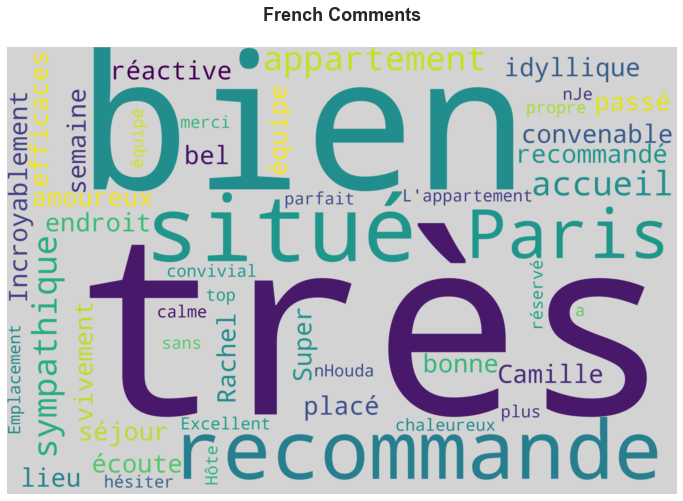

In [64]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('french')).generate(str(df_fr.commentaires.values))

plot_wordcloud(wordcloud, 'French')

English WordCloud

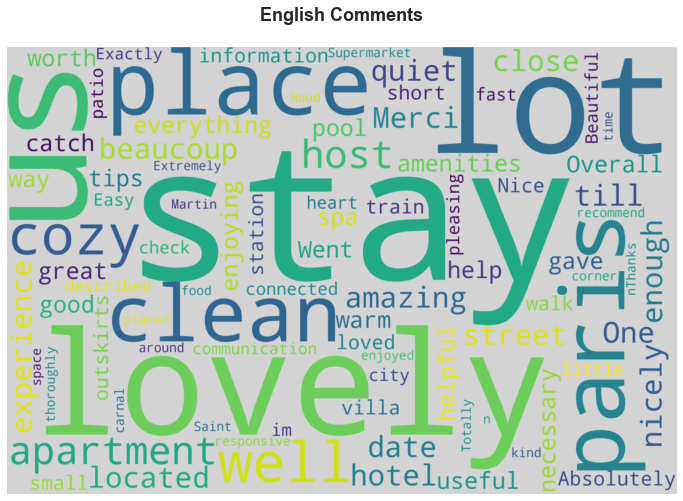

Wall time: 22 s


In [65]:
%%time
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_eng.commentaires.values))

plot_wordcloud(wordcloud, 'English')

Spanish WordCloud

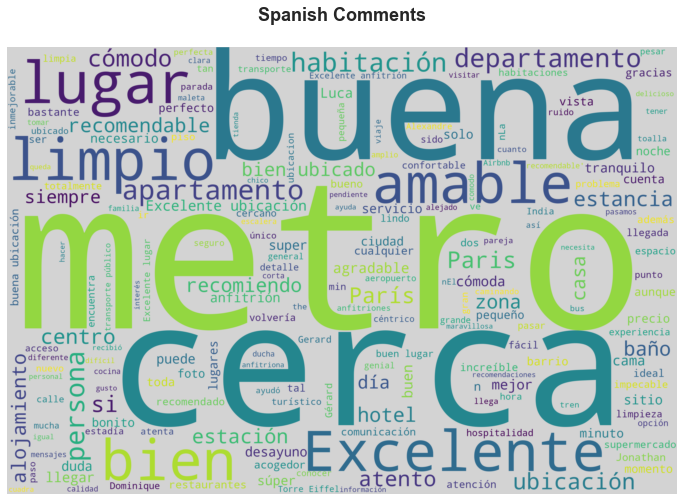

Wall time: 37.8 s


In [66]:
%%time
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('spanish')).generate(str(df_es.commentaires.values))

plot_wordcloud(wordcloud, 'Spanish')

Sentiments analysis

In [67]:
# load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# assign it to another name to make it easier to use
analyzer = SentimentIntensityAnalyzer()

In [68]:
# use the polarity_scores() method to get the sentiment metrics
def print_sentiment_scores(sentence):
    snt = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

In [69]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value


In [70]:
%%time

df_fr['sentiment_neg'] = df_fr['commentaires'].apply(negative_score)
df_fr['sentiment_neu'] = df_fr['commentaires'].apply(neutral_score)
df_fr['sentiment_pos'] = df_fr['commentaires'].apply(positive_score)
df_fr['sentiment_compound'] = df_fr['commentaires'].apply(compound_score)

Wall time: 23.3 s


In [71]:
%%time

df_eng['sentiment_neg'] = df_eng['commentaires'].apply(negative_score)
df_eng['sentiment_neu'] = df_eng['commentaires'].apply(neutral_score)
df_eng['sentiment_pos'] = df_eng['commentaires'].apply(positive_score)
df_eng['sentiment_compound'] = df_eng['commentaires'].apply(compound_score)

Wall time: 33.2 s


In [72]:
%%time

df_es['sentiment_neg'] = df_es['commentaires'].apply(negative_score)
df_es['sentiment_neu'] = df_es['commentaires'].apply(neutral_score)
df_es['sentiment_pos'] = df_es['commentaires'].apply(positive_score)
df_es['sentiment_compound'] = df_es['commentaires'].apply(compound_score)

Wall time: 2.16 s


In [73]:
def Plot_histograms(df):
    
    # all scores in 4 histograms
    fig, axes = plt.subplots(2, 2, figsize=(10,8))

    # plot all 4 histograms
    df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
    axes[0,0].set_title('Negative Sentiment Score')
    df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
    axes[0,1].set_title('Neutral Sentiment Score')
    df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
    axes[1,0].set_title('Positive Sentiment Score')
    df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
    axes[1,1].set_title('Compound')
    # plot common x- and y-label
    fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
    fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

    # plot title
    plt.suptitle('Sentiment Analysis of Airbnb Reviews for Berlin\n\n', fontsize=12, fontweight='bold');


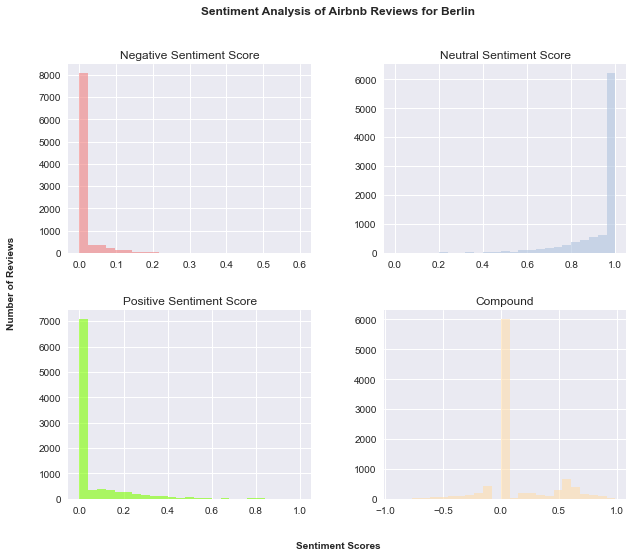

In [74]:
Plot_histograms(df_fr)

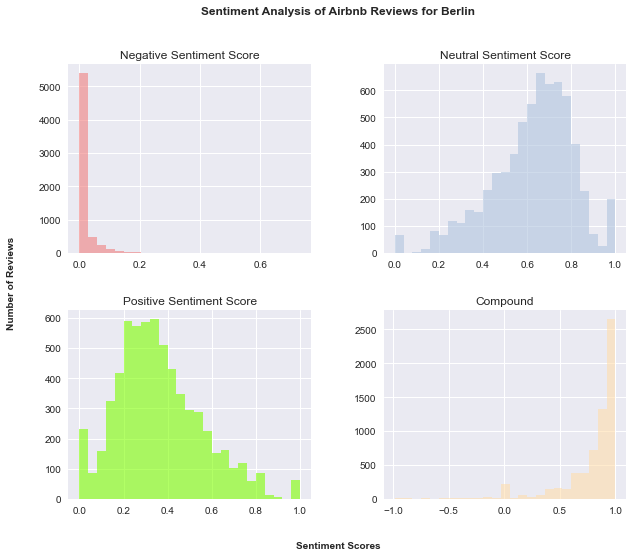

In [75]:
Plot_histograms(df_eng)

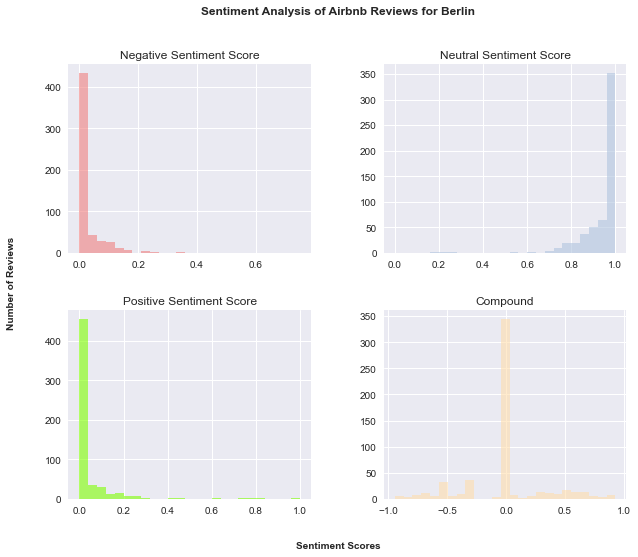

In [76]:
Plot_histograms(df_es)

 Comparing Negative and Positive Comments

In [86]:
def Comparaison(df):  
    percentiles = df.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])
    #assign the data
    neg = percentiles['5%']
    mid = percentiles['20%']
    pos = percentiles['max']
    names = ['Negative Comments', 'Okayish Comments','Positive Comments']
    size = [neg, mid, pos]

    # call a pie chart
    plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
            autopct='%.2f%%', pctdistance=0.8,
            wedgeprops={'linewidth':7, 'edgecolor':'white' })

    # create circle for the center of the plot to make the pie look like a donut
    my_circle = plt.Circle((0,0), 0.6, color='white')
    # plot the donut chart
    fig = plt.gcf()
    fig.set_size_inches(7,7)
    fig.gca().add_artist(my_circle)
    plt.show()

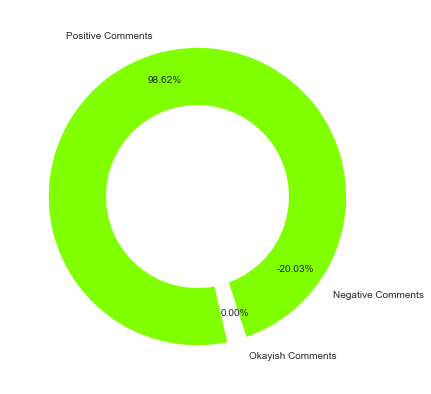

In [87]:
Comparaison(df_fr)

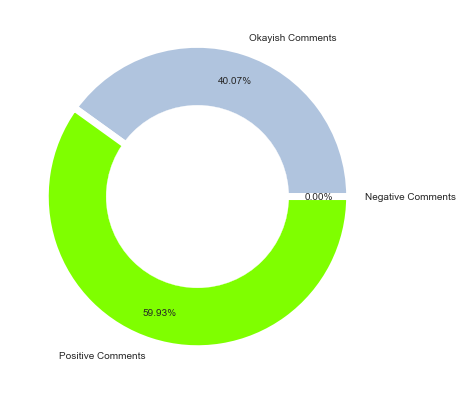

In [88]:
Comparaison(df_eng)

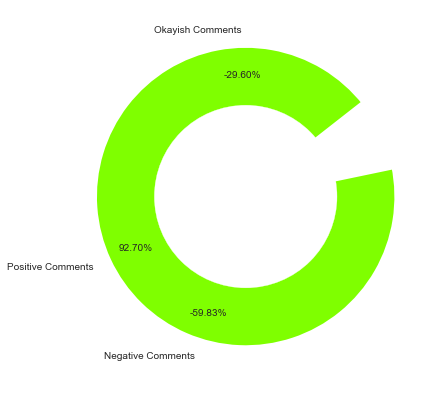

In [89]:
Comparaison(df_es)

In [119]:
def Distribution_of_s(df):
    # full dataframe with POSITIVE comments
    df_pos = df.loc[df.sentiment_compound >= 0.95]

    # only corpus of POSITIVE comments
    pos_comments = df_pos['commentaires'].tolist()
    # full dataframe with NEGATIVE comments
    df_neg = df.loc[df.sentiment_compound < 0.0]

    # only corpus of NEGATIVE comments
    neg_comments = df_neg['commentaires'].tolist()

    df_pos['text_length'] = df_pos['commentaires'].apply(len)
    df_neg['text_length'] = df_neg['commentaires'].apply(len)
    sns.set_style("whitegrid")
    plt.figure(figsize=(8,5))

    sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
    sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')
    plt.rcParams['axes.linewidth'] = 0.2
    plt.title('\nDistribution Plot for Length of Comments\n')
    plt.legend(['Positive Comments', 'Negative Comments'])
    plt.xlabel('\nText Length')
    plt.ylabel('Percentage of Comments\n')
    return df_pos, df_neg, pos_comments,neg_comments

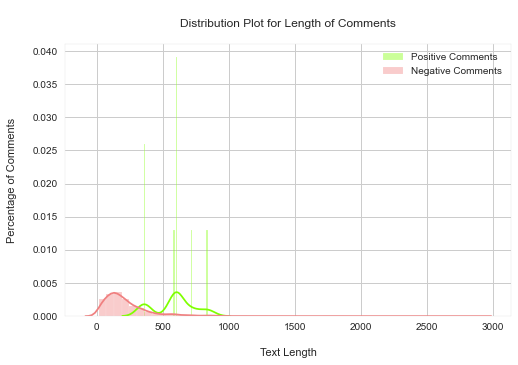

In [120]:
df_fr_c=Distribution_of_s(df_fr)

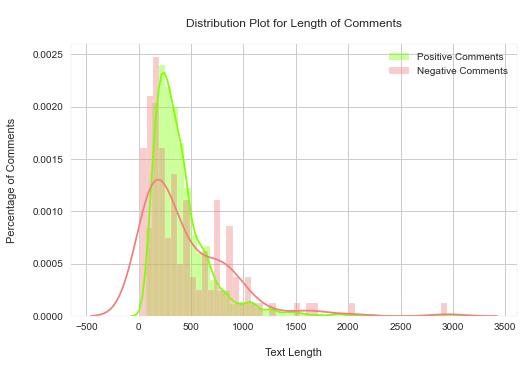

In [121]:
df_en_c=Distribution_of_s(df_eng)

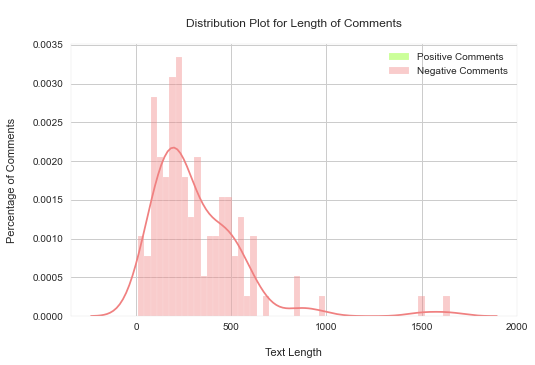

In [122]:
df_es_c=Distribution_of_s(df_es)

In [128]:
df_fr_c[2][1:5]

['Son appartement est vraiment magnifique et elle est super gentille et accueillante. Elle est cultivée et sympa. L’appartement est très propre et dans un quartier très agréable. 5 stars! <3\n\nHer apartment is really beautiful and she is super nice and welcoming.  She is cultured and friendly.  The apartment is very clean and in a very nice area.  5 stars!  <3',
 'Gerard was an amazing host!!! He was incredibly corteous and friendly and his home was lovely - exactly as described. He made a beautiful breakfast (with homemade bread) for me every morning and was happy to fulfill any special request made. I will definitely stay here again! :) \n\nGérard était un hôte incroyable !!! Il était incroyablement courtois et sympathique et sa maison était très agréable - exactement comme décrit. Il a fait un beau petit déjeuner (avec du pain maison) pour moi chaque matin et était heureux de répondre à toute demande spéciale faite. Je vais certainement rester ici encore! :)',
 'Son appartement est

 Investigating Positive Comments

In [133]:
def Investigate(df,language):
    
    wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="palegreen",
                          width= 3000, height = 2000,
                          stopwords = stopwords.words(language)).generate(str(df.commentaires.values))

    plot_wordcloud(wordcloud, '\nPositively Tuned')

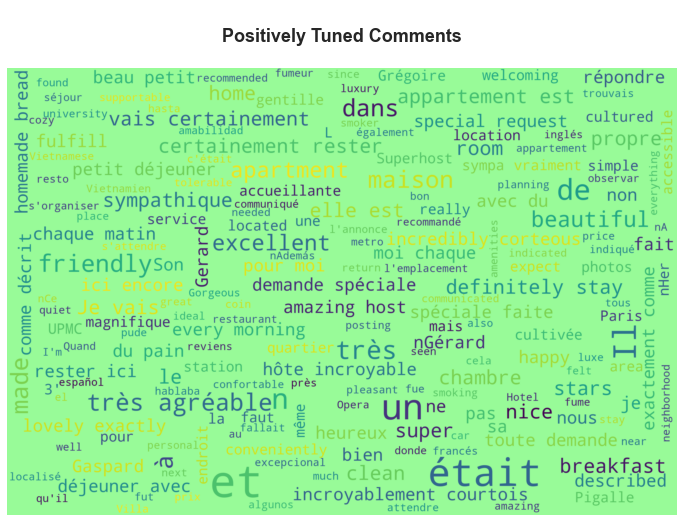

Wall time: 24.4 s


In [135]:
%%time
Investigate(df_fr_c[0],'English')

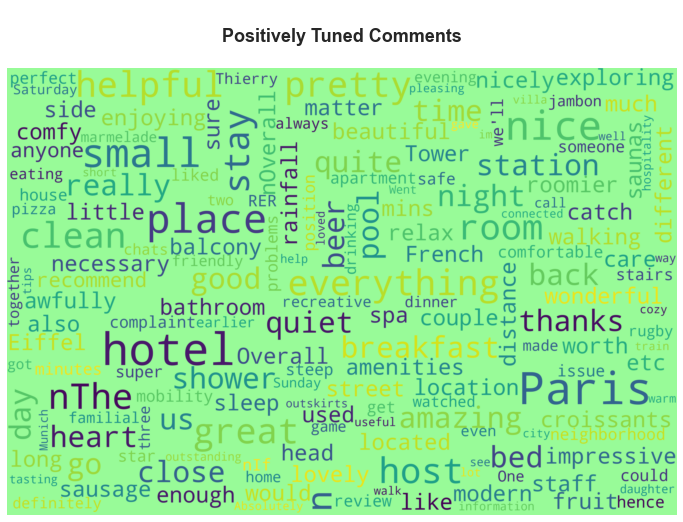

Wall time: 21.8 s


In [137]:
%%time
Investigate(df_en_c[0],'English')

In [140]:
!pip install yellowbrick

In [141]:
# importing libraries
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette

In [144]:
def visualisition_pos(df,language):
    
    vectorizer = CountVectorizer(stop_words=language)
    docs = vectorizer.fit_transform(df)
    features = vectorizer.get_feature_names()

    # preparing the plot
    set_palette('pastel')
    plt.figure(figsize=(18,8))
    plt.title('The Top 30 most frequent words used in POSITIVE comments\n', fontweight='bold')

    # instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
    visualizer = FreqDistVisualizer(features=features, n=30)
    visualizer.fit(docs)
    visualizer.poof;

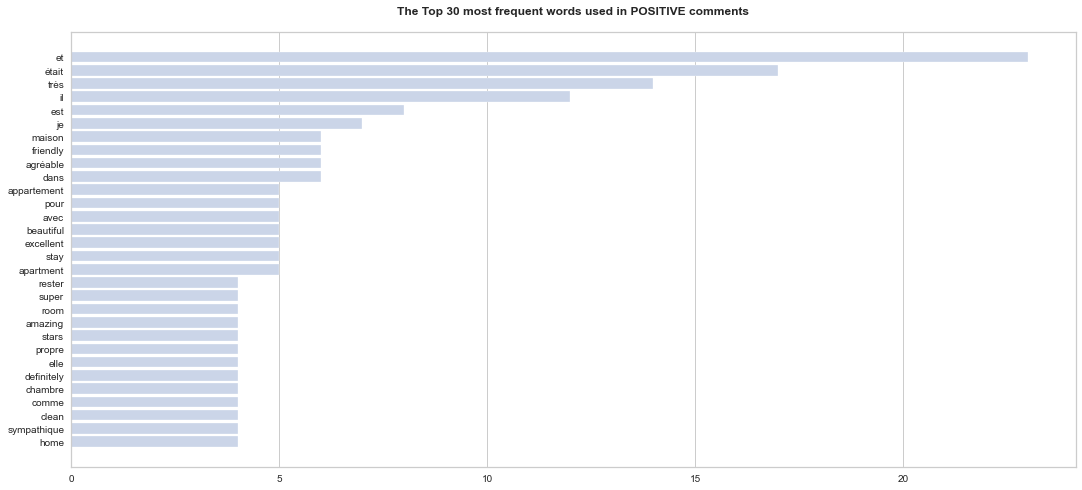

In [152]:
visualisition_pos(df_fr_c[2],'english')

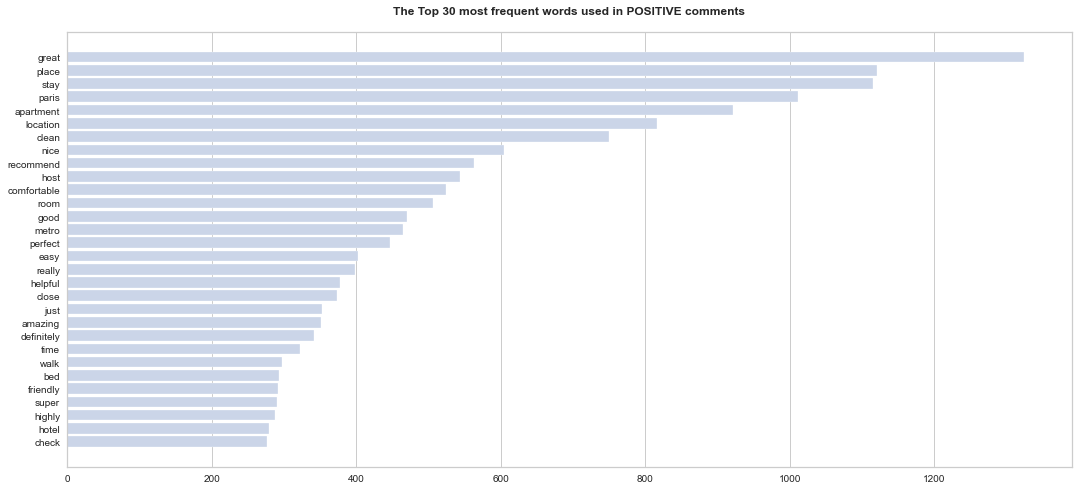

In [150]:
visualisition_pos(df_en_c[2],'english')

In [165]:
n=pd.value_counts(df_fr['index'])

In [168]:
n.sum()

9536

In [226]:
n=pd.value_counts(df_fr['index'])
m=pd.value_counts(df_eng['index'])
z=pd.value_counts(df_es['index'])

In [244]:
df_fr_=

In [251]:
df_test['sentiment_compound']

index
1.0      0.000000
2.0      0.166171
3.0      0.012793
7.0      0.197256
8.0      0.080893
           ...   
281.0    0.076778
282.0    0.167452
283.0    0.077169
284.0    0.059557
285.0    0.327917
Name: sentiment_compound, Length: 218, dtype: float64

In [260]:
fr=df_fr[['numero_listing','sentiment_neg','sentiment_pos','sentiment_neu','sentiment_compound' ]].groupby('numero_listing').mean()

In [261]:
eng=df_eng[['numero_listing','sentiment_neg','sentiment_pos','sentiment_neu','sentiment_compound' ]].groupby('numero_listing').mean()

In [262]:
es=df_es[['numero_listing','sentiment_neg','sentiment_pos','sentiment_neu','sentiment_compound' ]].groupby('numero_listing').mean()

In [172]:
##sentiment_compound moyen pour chaque listing sur l'ensemble des commentaires
##il s'agit s'une moyenne arithmetique sur les sentiment_compound de chaque listing dans les trois bases

(9536, 13) (6421, 13) (572, 13)


In [233]:
fr_test=df_fr[['index','sentiment_neg','sentiment_pos','sentiment_neu','sentiment_compound' ]].groupby('index').mean()

index    int64
dtype: object

In [304]:
sentiment_compound_moy=[]
sentiment_neg_moy=[]
sentiment_pos_moy=[]
numero_listings=[]
p=0
for i in range(1,286):
    a=0
    b=0
    c=0
    if (i in n.keys() and i in fr.sentiment_compound.keys()) : 
        try:
            a=a+n[i]*fr.sentiment_compound[i]
            b=b+n[i]*fr.sentiment_pos[i]
            c=c+n[i]*fr.sentiment_neg[i]
            p=p+n[i]
        except: pass
    if (i in m.keys() and i in eng.sentiment_compound.keys()) : 
        try:
            a=a+m[i]*eng.sentiment_compound[i]
            b=b+m[i]*eng.sentiment_pos[i]
            c=c+m[i]*eng.sentiment_neg[i]
            p=p+m[i]
        except: pass
    if (i in z.keys() and i in es.sentiment_compound.keys()) : 
        try:
            a=a+z[i]*es.sentiment_compound[i]   
            b=b+z[i]*es.sentiment_pos[i]
            c=c+z[i]*es.sentiment_neg[i]
            p=p+z[i]
        except: pass
    if p!=0:
        a=a/p
        b=b/p
        c=c/p
    numero_listings.append(i)
    sentiment_compound_moy.append(a)
    sentiment_pos_moy.append(b)
    sentiment_neg_moy.append(c)

    

In [284]:
sentiment=pd.DataFrame.from_dict({'numero_listings':numero_listings,'sentiment_compound_moy':sentiment_compound_moy})#'sentiment_pos_moy':sentiment_pos_moy,'sentiment_neg_moy':sentiment_neg_moy})

In [286]:
sentiment.shape

(285, 2)

In [305]:
sentiments=pd.DataFrame.from_dict({'numero_listings':numero_listings,'sentiment_pos_moy':sentiment_pos_moy,'sentiment_neg_moy':sentiment_neg_moy,'sentiment_compound_moy':sentiment_compound_moy})#'sentiment_pos_moy':sentiment_pos_moy,'sentiment_neg_moy':sentiment_neg_moy})

In [306]:
sentiments.head(50)

,numero_listings,sentiment_pos_moy,sentiment_neg_moy,sentiment_compound_moy
0,1,0.000000,0.000000,0.000000
1,2,0.302149,0.011673,0.605195
2,3,0.002087,0.001158,0.005340
3,4,0.000000,0.000000,0.000000
4,5,0.000000,0.000000,0.000000
5,6,0.000000,0.000000,0.000000
6,7,0.076965,0.017998,0.113729
7,8,0.064184,0.006295,0.095896
8,9,0.069813,0.005289,0.162288
9,10,0.067443,0.006412,0.141880
